# Estimating Cultural Loss with Copia

### _Folgert Karsdorp_ 

---

<div>
<img src="./images/copia.png" width="150" style="float: right; margin: 10px;"/>
</div>

Copia is a statistical software package designed for estimating diversity and richness based on abundance data. It incorporates several bias-correcting richness estimators, including the Chao1 estimator, aiding in a more accurate exploration of unseen entities in various datasets. This notebook serves as an introduction to applying unseen species models to cultural data using Copia.

We'll kick-start our tutorial with a brief exploration of a dataset comprising medieval Dutch manuscripts. This initial exercise aims to familiarize you with Copia’s functionalities and the foundational principles of unseen species models.

Following this, we will delve into a more detailed analysis using Darwin's correspondence corpus. The objective here is to estimate the number of Darwin's correspondents that remain unseen. Through this exercise, we aim to demonstrate the practical application of Copia in estimating unseen entities in historical or cultural datasets, thereby providing you a blueprint to explore your own datasets.

## Copia: A Quickstart

### Installing Copia:

Copia can be easily installed from PyPi using pip. Run the following command to install Copia on your machine:
```bash
python -m pip install copia
```

### Data Source

<div>
<img src="./images/spiegel-der-letteren.png" width="450" style="float: right; margin: 10px;"/>
</div>

The data for this first part of the tutorial is sourced from the study by Kestemont & Karsdorp (2019), which marked our initial exploration into the realm of unseen medieval literature using statistical methods.

### Study Abstract


The study addresses a key challenge in historical literature research: the incomplete transmission of sources over centuries, leading to a potential underestimation of the literary diversity of the past. By employing eco-diversity statistical methods on Middle Dutch chivalric epics, the study suggests that previous estimates of text loss might have been too conservative. These methods unveil that up to half, or possibly more, of the original texts may have been lost over time, highlighting the need for quantitative tools to adjust our understanding of historical literary diversity.

### Loading the Data

We will utilize the Pandas library to load our dataset for analysis. The following section provides the necessary code and instructions to successfully load and prepare the data for our exploration using Copia.

In [1]:
import pandas as pd

df = pd.read_csv('data/dutch.csv', sep=';')
df.columns = 'work', 'signature'
df.head()

,work,signature
0,Aiol (2),"Breda, Arch. Begijnhof, z.s."
1,Alexanders geesten,"München, Bayerische Staatsbibliotheek, Cod. ge..."
2,Alexanders geesten,"Gent, UB, 2749,6"
3,Alexanders geesten,"Leiden, UB, Ltk. 1196"
4,Alexanders geesten,"Donaueschingen, Fürstl. Fürstenb. Hofbibl., 173"


### Extracting data

The Chao1 estimator formula necessitates the provision of two key parameters from our collection: the number of items occurring once ($f_1$) and the number of items occurring twice ($f_2$). These parameters are pivotal for estimating the unseen diversity in our dataset.

Copia comes with a utility function designed to streamline the conversion of our list of works into abundance data, aligning with the requirements of the Chao1 estimator. Below, we will demonstrate how to employ this utility function to prepare our dataset for further analysis:

In [2]:
import copia.utils

abundance = copia.utils.to_abundance(df['work'])
abundance

array([ 1,  5,  2,  1,  2,  1,  1,  2,  2,  3,  3,  1,  1,  2,  1,  1,  1,
        1,  2,  1,  1,  1,  1,  1,  1,  4,  1,  1,  7,  1,  1,  3,  1, 10,
        1,  3,  2, 10,  4,  2,  1,  3,  6,  5,  2,  5,  2,  5,  1,  1,  1,
        1,  1,  2, 17,  2,  1,  1,  2,  1,  1,  1,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1])

<div class="alert alert-block alert-success">
    <b>Note:</b> The functionality illustrated above can also be achieved using the following code, which exclusively utilizes Pandas:
</div>

In [3]:
df['work'].value_counts().values

array([17, 10, 10,  7,  6,  5,  5,  5,  5,  4,  4,  3,  3,  3,  3,  3,  3,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1])

### Summarizing abundance data

Copia provides a suite of statistical functions to summarize the data, one of which is the `basic_stats` function. As demonstrated in the subsequent code block, this function returns various metrics including the count of items occurring once ($f_1$), twice ($f_2$), and up to four times ($f_4$). Additionally, it provides the observed number of unique items ($S$) and the total number of observations ($n$):

In [4]:
copia.utils.basic_stats(abundance)

{'f1': 44, 'f2': 13, 'f3': 6, 'f4': 2, 'S': 74, 'n': 166}

One of the advantageous features of Copia is its ability to facilitate easy visualization of abundance data. This step is often crucial before applying unseen species estimators since these estimators are dependent on values of $f_1$ and $f_2$. It's essential to ensure these values are present in the data. The code block below demonstrates how to visualize the abundance data as a histogram using Copia's plotting utilities:

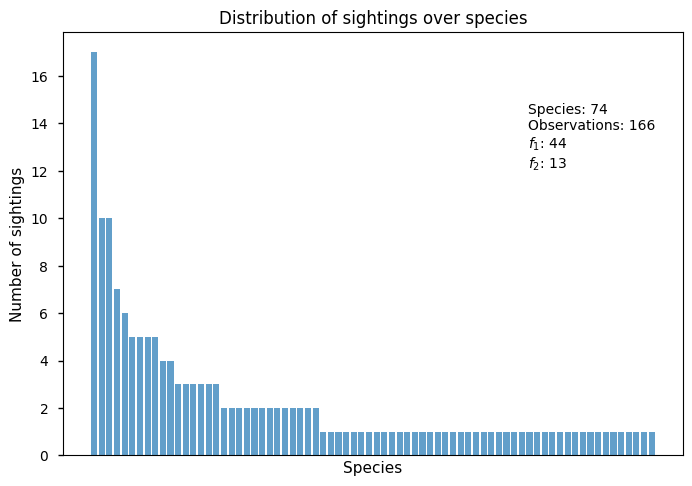

In [5]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-notebook")

import copia.plot

copia.plot.abundance_counts(abundance);

Alternatively, Copia allows for the visualization of abundance counts per frequency category, which can provide insightful perspectives on the distribution of item occurrences within the dataset. In the following demonstration, we'll plot the count of items occurring once, twice, and so forth:

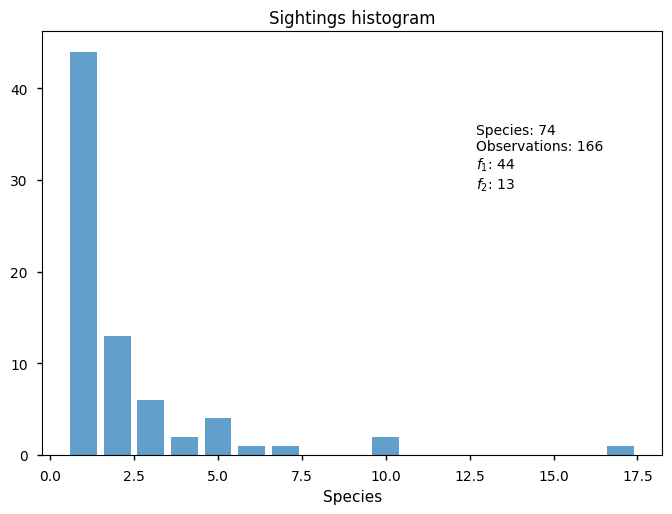

In [6]:
copia.plot.abundance_histogram(abundance);

### Species Richness

Utilize Copia's `copia.richness` module to estimate unbiased diversity using one of the available estimators. All estimators can be accessed through a single entry point, the `diversity()` function:

In [7]:
from copia.richness import diversity

round(diversity(abundance, method='chao1'))

148

Copia includes a variety of estimators for your convenience:

In [8]:
for m in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    print(m, '->', round(diversity(abundance, method=m)))

chao1 -> 148
ichao1 -> 166
ace -> 148
jackknife -> 173
egghe_proot -> 165


For retrieving empirical species richness or the population size, you can use the following commands:

In [9]:
print('species richness:', diversity(abundance, method='empirical'))
print('population size:', diversity(abundance, method='empirical', species=False))

species richness: 74
population size: 166


### Bootstrapped Estimation

The Chao1 estimator provides a lower bound estimate of the unseen species count. However, this estimate itself has an associated range, defined by a lower and upper bound, which represents the confidence interval around the estimate. Two common approaches to obtaining this confidence interval include analytical solutions or bootstrap procedures. In Copia, the bootstrap procedure is implemented to derive these bounds. To enable this feature, set the `CI` parameter to `True` when calling the function. This will return a dictionary containing the relevant keys, including the actual bootstrap values:

In [10]:
D = diversity(abundance, method='chao1', CI=True, n_iter=1000, n_jobs=4)
D.keys()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 481.98it/s]


dict_keys(['richness', 'lci', 'uci', 'std', 'bootstrap'])

It's possible to visualize the distribution of these bootstrap values using a histogram. This visual representation can provide a clearer understanding of the confidence interval around the Chao1 estimate:

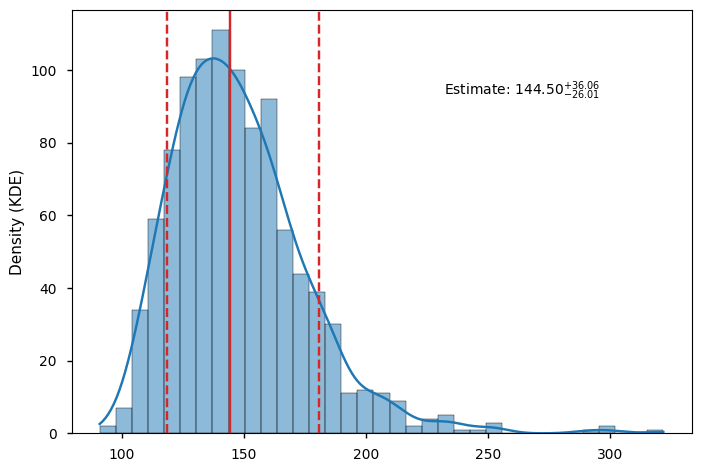

In [11]:
copia.plot.density(D);

Copia includes a utility function to calculate these estimates as "survival ratios," which are bounded between 0 and 1. This normalized representation can be particularly insightful. Additionally, Copia facilitates the visualization of these ratios using the `density()` function, as demonstrated below:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 497.52it/s]


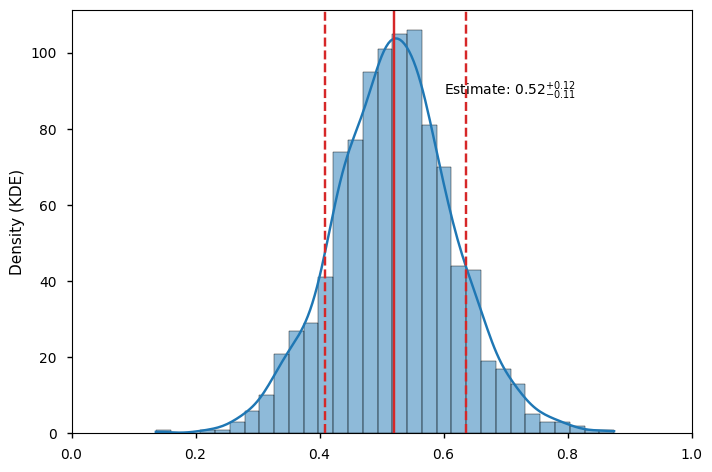

In [12]:
from copia.utils import survival_ratio

survival = survival_ratio(abundance, method='chao1', n_iter=1000, n_jobs=4)
copia.plot.density(survival, xlim=(0, 1));

### Species Accumulation

Species Accumulation curves elucidate the relationship between the number of unique species and the increment in sample size (i.e., the number of observations). With Copia, you can compute this relationship effortlessly using the `species_accumulation()` function. Examine the following code snippet for a practical demonstration:

In [13]:
from copia.richness import species_accumulation

accumulation = species_accumulation(abundance, max_steps=4000, n_iter=1000)
accumulation

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.35it/s]


{'richness': array([  1.        ,   1.97480832,   2.92579943, ..., 148.01289151,
        148.01289181, 148.01289211]),
 'lci': array([  1.        ,   1.96330975,   2.89312878, ..., 108.27845888,
        108.27844445, 108.27843004]),
 'uci': array([  1.        ,   1.98303958,   2.9494987 , ..., 218.53788229,
        218.53788578, 218.53788925]),
 'std': array([4.44953479e-13, 5.12771761e-03, 1.46363324e-02, ...,
        2.87914830e+01, 2.87915470e+01, 2.87916110e+01]),
 'bootstrap': array([[  1.        ,   1.98303775,   2.94931296, ..., 130.51846609,
         130.51845167, 130.51843726],
        [  1.        ,   1.97814545,   2.93529325, ..., 158.76217153,
         158.76215725, 158.76214299],
        [  1.        ,   1.98048207,   2.94195448, ..., 146.11768962,
         146.1176752 , 146.1176608 ],
        ...,
        [  1.        ,   1.96909106,   2.90947378, ..., 141.31895695,
         141.31894253, 141.31892814],
        [  1.        ,   1.97872961,   2.93674651, ..., 147.17711471,

We can visualize the species accumulation using Copia's `accumulation_curve()` function. The following code snippet demonstrates how to plot the accumulation curve:

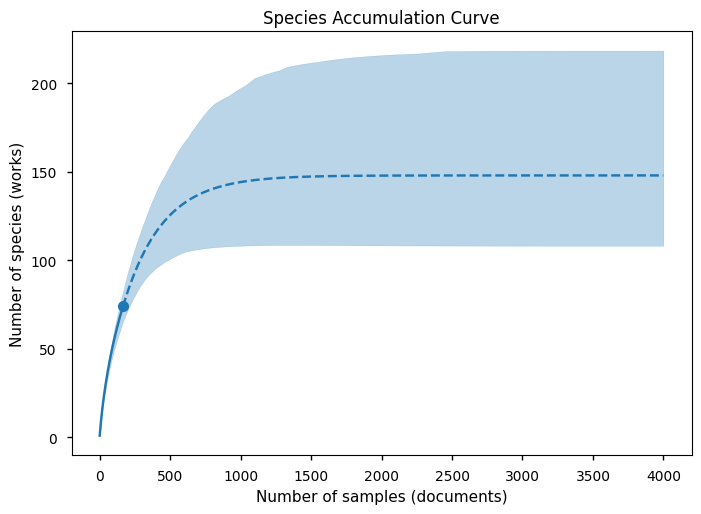

In [14]:
from copia.plot import accumulation_curve

copia.plot.accumulation_curve(
    abundance, accumulation,
    xlabel='Number of samples (documents)', ylabel='Number of species (works)',
    title='Species Accumulation Curve');

In the plotted curve, the blue dot represents the empirical species richness. To its left, the interpolated accumulation of species with increased sampling is depicted. On the right, a projection into the future is illustrated, showing the anticipated discovery of new species or works with further document sampling. Notably, the curve begins to flatten around 1500 documents, suggesting that beyond this point, no new unseen works are expected to be found according to the estimator.


### Minimum Additional Sampling

To ascertain a more precise estimate of the additional sampling required to discover all unique species, Copia offers the "**minimum additional sampling**" method. This method provides a less conventional unbiased estimator to obtain a lower bound on the true population size, thus gauging the minimum number of samples needed to uncover the estimated species richness. Here's how you can utilize this method:

In [15]:
round(diversity(abundance, method='minsample'))

2142

This output indicates that a minimum of 2142 samples is required to reach the estimated species richness. For a more robust understanding, a bootstrap procedure is available to compute the confidence intervals of this number:

In [16]:
minsample = diversity(abundance, method='minsample', CI=True, n_iter=1000, n_jobs=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.13it/s]


Lastly, plotting the results as a histogram and comparing the median estimate to the position in the accumulation curve plot can provide a visual comprehension of these estimates:

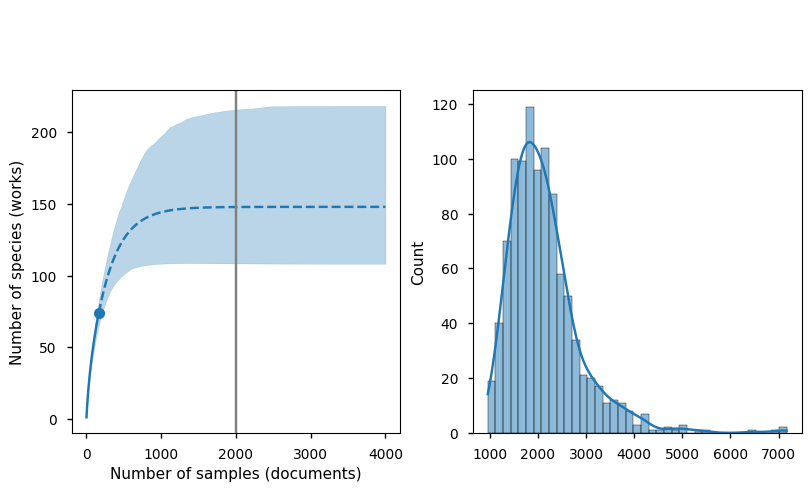

In [17]:
import numpy as np
import seaborn as sns
from matplotlib.patches import ConnectionPatch

fig, (accum_ax, minsample_ax) = plt.subplots(ncols=2, constrained_layout=True, figsize=(8, 4))
copia.plot.accumulation_curve(
    abundance, accumulation, ax=accum_ax,
    xlabel='Number of samples (documents)', ylabel='Number of species (works)');

minsample_estimate = np.median(minsample["bootstrap"])
accum_ax.axvline(minsample_estimate, color="grey", label="Minsample estimate");

sns.histplot(minsample['bootstrap'], kde=True, ax=minsample_ax)

xyA = (minsample_estimate, 200)
xyB = (minsample_estimate, 140)

# Create the arrow using ConnectionPatch and add it to the figure
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                      axesA=accum_ax, axesB=minsample_ax, 
                      connectionstyle="arc3,rad=-0.5",
                      arrowstyle="-|>", color="black")
fig.add_artist(con);

# Case Study: Darwin's Unseen Correspondents

Now that we have acquainted ourselves with the Copia package and the underlying principles of unseen species models, it's time to dive into a real-world dataset - The Correspondence of Charles Darwin. Despite the extensive corpus of over 15,000 letters, new correspondences continue to emerge, hinting at the existence of unseen correspondents.

In this hands-on session, we will apply the tools and techniques learned to estimate the unseen correspondents in Darwin's correspondence network. Additionally, we will explore the variations in survival ratios across different years and ascertain the minimal additional sampling needed to complete the correspondence network.

This exercise aims to reinforce the concepts learned, foster collaborative problem-solving, and provide a practical insight into the application of unseen species models in historical or cultural datasets. Ready to delve into the unseen narrative of Darwin's correspondences? Let's get started!

### Loading the data

We start by loading the data, which is stored as a csv table in the data folder:

In [22]:
import pandas as pd

df = pd.read_csv("data/darwin-correspondence.csv", parse_dates=["sorting_date"])
df['sorting_date'] = pd.DatetimeIndex(df['sorting_date'])
df.sample(5)

,id,sender_surname,sender_forename,recipient_surname,recipient_forename,sorting_date,date,sender_address,recipient_address,source,languages,extent,filename
10555,DCP-LETT-9731,Darwin,C. R.,Sharpe,R. B.,1874-11-24,24 Nov [1874],Down,NaN,DAR 97: C66,NaN,NaN,DCP-LETT-9731.xml
3527,DCP-LETT-3216,Darwin,C. R.,Gray,Asa,1861-07-21,21 July [1861],Torquay,NaN,Gray Herbarium of Harvard University (61),NaN,NaN,DCP-LETT-3216.xml
14491,DCP-LETT-13243,Darwin,C. R.,Wallace,A. R.,1881-07-12,12 July 1881,Down,NaN,The British Library (Add MS 46434),NaN,NaN,DCP-LETT-13243.xml
8100,DCP-LETT-7512F,Darwin,C. R.,Wallace,A. R.,1866-11-23,[23 Nov 1866?],"London Queen Anne St, 6",NaN,Alexander Historical Auctions (dealers) (29 Ap...,NaN,NaN,DCP-LETT-7512F.xml
1693,DCP-LETT-1531,Darwin,C. R.,Johnston,George,1853-09-06,6 Sept 1853,Down,NaN,DAR 146: 7,NaN,NaN,DCP-LETT-1531.xml


The archive consists of 15228 letters:

## Instructions

1. **Group Formation:**
   1. Form small groups of 3-4 participants.
2. **Dataset Exploration:**
   1. Load the Darwin correspondence dataset.
   2. Familiarize yourself with the dataset structure and contents.
3. **Estimation of Unseen Correspondents:**
   1. Apply the tools learned to estimate the number of unseen correspondents in the dataset.
4. **Survival Ratios Analysis:**
   1. Analyze the survival ratios between different years.
   2. Visualize the findings for a clearer understanding.
5. **Minimal Additional Sampling:**
   1. Determine the minimal additional sampling needed to complete the correspondence network.
6. **Discussion and Compilation:**
   1. Discuss the findings within your group.
   2. Prepare a brief presentation summarizing your methodology, findings, and any challenges encountered.
7. **Presentation:**
   1. Each group will have 5 minutes to present their findings.

You have 30 to 45 minutes to complete this exercise. Feel free to reach out if you have any questions or encounter any issues during the session. Good luck!